# User-Friendly Workflow Tutorial

In this notebook we present the a __user-friendly approach__ in the well-known ABT-BUY dataset. This is a simple approach, specially developed for novice users in ER.

# How to install?

pyJedAI is an open-source library that can be installed from PyPI.


In [ ]:
!pip install pyjedai -U

In [2]:
!pip show pyjedai

Name: pyjedai
Version: 0.1.0
Summary: An open-source library that builds powerful end-to-end Entity Resolution workflows.
Home-page: 
Author: 
Author-email: Konstantinos Nikoletos <nikoletos.kon@gmail.com>, George Papadakis <gpapadis84@gmail.com>, Jakub Maciejewski <jacobb.maciejewski@gmail.com>, Manolis Koubarakis <koubarak@di.uoa.gr>
License: Apache Software License 2.0
Location: /home/jm/anaconda3/envs/pyjedai-new/lib/python3.8/site-packages
Requires: faiss-cpu, gensim, matplotlib, matplotlib-inline, networkx, nltk, numpy, optuna, ordered-set, pandas, pandas-profiling, pandocfilters, plotly, py-stringmatching, PyYAML, rdflib, rdfpandas, regex, scipy, seaborn, sentence-transformers, strsim, strsimpy, tomli, tqdm, transformers, valentine
Required-by: 


Imports

In [3]:
import os
import sys
import pandas as pd

## Data Reading

In [4]:
from pyjedai.datamodel import Data

data = Data(
    dataset_1=pd.read_csv("./../data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str),
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=pd.read_csv("./../data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str),
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=pd.read_csv("./../data/ccer/D2/gt.csv", sep='|', engine='python'),
)

[nltk_data] Downloading package stopwords to /home/jm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## WorkFlow

In [5]:
from pyjedai.workflow import BlockingBasedWorkFlow, EmbeddingsNNWorkFlow, compare_workflows
from pyjedai.block_building import StandardBlocking, QGramsBlocking, ExtendedQGramsBlocking, SuffixArraysBlocking, ExtendedSuffixArraysBlocking
from pyjedai.block_cleaning import BlockFiltering, BlockPurging
from pyjedai.comparison_cleaning import WeightedEdgePruning, WeightedNodePruning, CardinalityEdgePruning, CardinalityNodePruning, BLAST, ReciprocalCardinalityNodePruning, ReciprocalWeightedNodePruning, ComparisonPropagation
from pyjedai.matching import EntityMatching
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering
from pyjedai.vector_based_blocking import EmbeddingsNNBlockBuilding

In [6]:
w = BlockingBasedWorkFlow(
    block_building = dict(
        method=QGramsBlocking,
        params=dict(qgrams=3),
        attributes_1=['name'],
        attributes_2=['name']
    ),
    block_cleaning = [
        dict(
            method=BlockPurging, 
            params=dict(smoothing_factor=1.025)
        ),
        dict(
            method=BlockFiltering,
            params=dict(ratio=0.8)
        )
    ],
    comparison_cleaning = dict(method=CardinalityEdgePruning),
        entity_matching = dict(
        method=EntityMatching,
        metric='sorensen_dice',
        similarity_threshold=0.5,
        attributes = ['description', 'name']
    ),
    clustering = dict(method=ConnectedComponentsClustering),
    name="Worflow-Test"
)

In [7]:
w.run(data, verbose=True)

***************************************************************************************************************************
                                         Μethod:  Q-Grams Blocking
***************************************************************************************************************************
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 3
Runtime: 0.7395 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.08% 
	Recall:       100.00%
	F1-score:       0.17%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
***************************************************************************************************************************
                                         Μethod:  Block Purging
**************************************************************************************

In [8]:
w.to_df()

,Algorithm,F1,Recall,Precision,Runtime (sec),Params
0,Q-Grams Blocking,0.167526,100.000000,0.083833,0.739494,{'Q-Gramms': 3}
1,Block Purging,0.190665,100.000000,0.095423,0.044369,"{'Smoothing factor': 1.025, 'Max Comparisons p..."
2,Block Filtering,0.493133,99.907063,0.247176,0.479028,{'Ratio': 0.8}
3,Cardinality Edge Pruning,8.985532,98.698885,4.707030,2.709405,"{'Node centric': False, 'Weighting scheme': 'JS'}"
4,Entity Matching,3.807797,1.951673,77.777778,11.143954,"{'Metric': 'dice', 'Attributes': None, 'Simila..."
5,Connected Components Clustering,3.463993,1.765799,90.476190,0.001340,{}


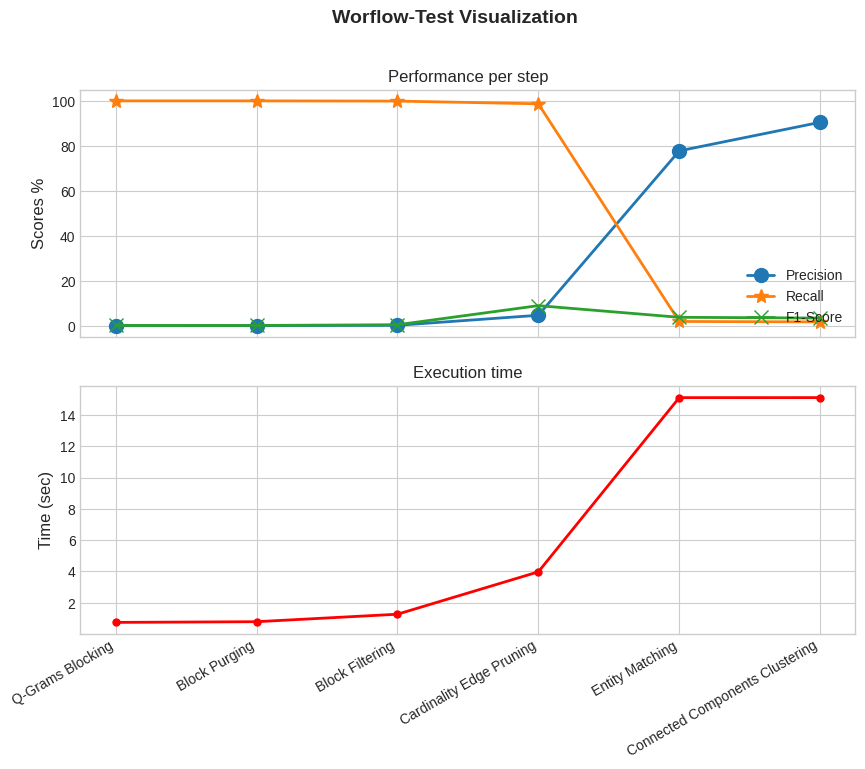

In [9]:
w.visualize()

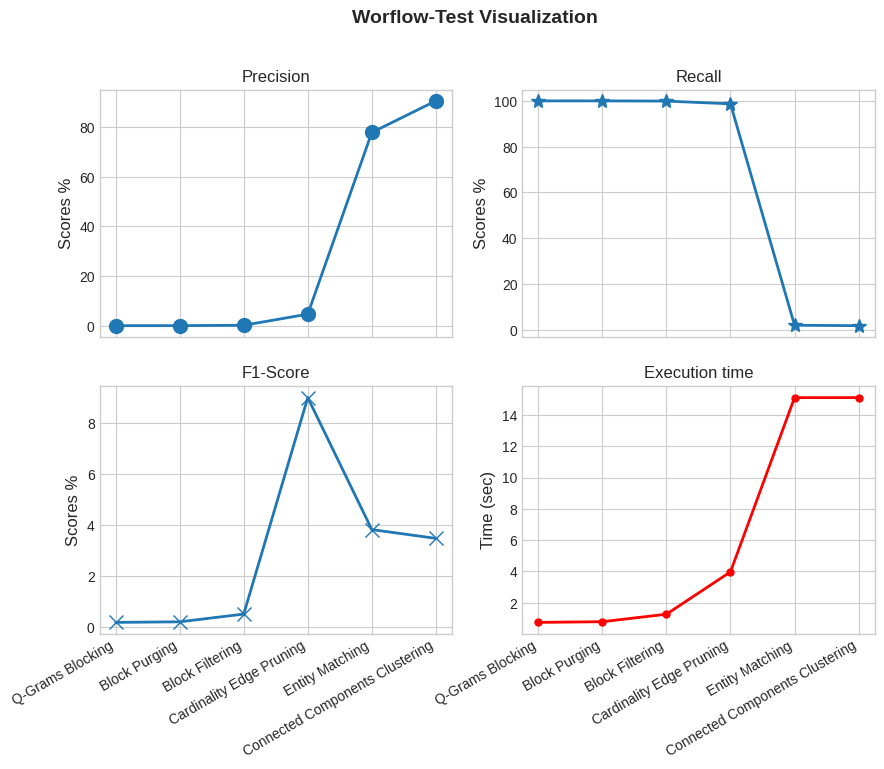

In [10]:
w.visualize(separate=True)

## Multiple workflows - Comparison

In [11]:
w1 = BlockingBasedWorkFlow(
    block_building = dict(
        method=QGramsBlocking, 
        params=dict(qgrams=4),
        attributes_1=['name'],
        attributes_2=['name']
    ),
    block_cleaning = [
        dict(
            method=BlockFiltering, 
            params=dict(ratio=0.6)
        ),
        dict(
            method=BlockPurging, 
            params=dict(smoothing_factor=1.025)
        )
    ],
    comparison_cleaning = dict(method=CardinalityEdgePruning),
        entity_matching = dict(
        method=EntityMatching, 
        metric='sorensen_dice',
        similarity_threshold=0.5,
        attributes = ['description', 'name']
    ),
    clustering = dict(method=ConnectedComponentsClustering)
)
w1.run(data, verbose=False, workflow_tqdm_enable=True)

BlockingBasedWorkFlow-1:   0%|          | 0/5 [00:00<?, ?it/s]

## Workflow based on pyTorch Embdeddings


- `block_building` : 
    - `method` : EmbeddingsNNBlockBuilding
    - `params` : Constructor parameters
    - `exec_params` : `build_blocks` parameters
- `clustering` : 
    - `method` : UniqueMappingClustering
    - `params` : Constructor parameters (i.e similarity threshold)

In [12]:
w2 = EmbeddingsNNWorkFlow(
    block_building = dict(
        method=EmbeddingsNNBlockBuilding, 
        params=dict(vectorizer='sminilm', similarity_search='faiss'),
        exec_params=dict(top_k=5, 
                         similarity_distance='euclidean',
                         load_embeddings_if_exist=False,
                         save_embeddings=False)
    ),
    clustering = dict(method=UniqueMappingClustering),
    name="EmbeddingsNNWorkFlow-Test"
)

w2.run(data, verbose=True)

Building blocks via Embeddings-NN Block Building [sminilm, faiss]


Embeddings-NN Block Building [sminilm, faiss]:   0%|          | 0/2152 [00:00<?, ?it/s]

Device selected:  cpu
***************************************************************************************************************************
                                         Μethod:  Embeddings-NN Block Building
***************************************************************************************************************************
Method name: Embeddings-NN Block Building
Parameters: 
	Vectorizer: sminilm
	Similarity-Search: faiss
	Top-K: 5
	Vector size: 384
Runtime: 163.8474 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      9.17% 
	Recall:        91.73%
	F1-score:      16.68%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
***************************************************************************************************************************
                                        

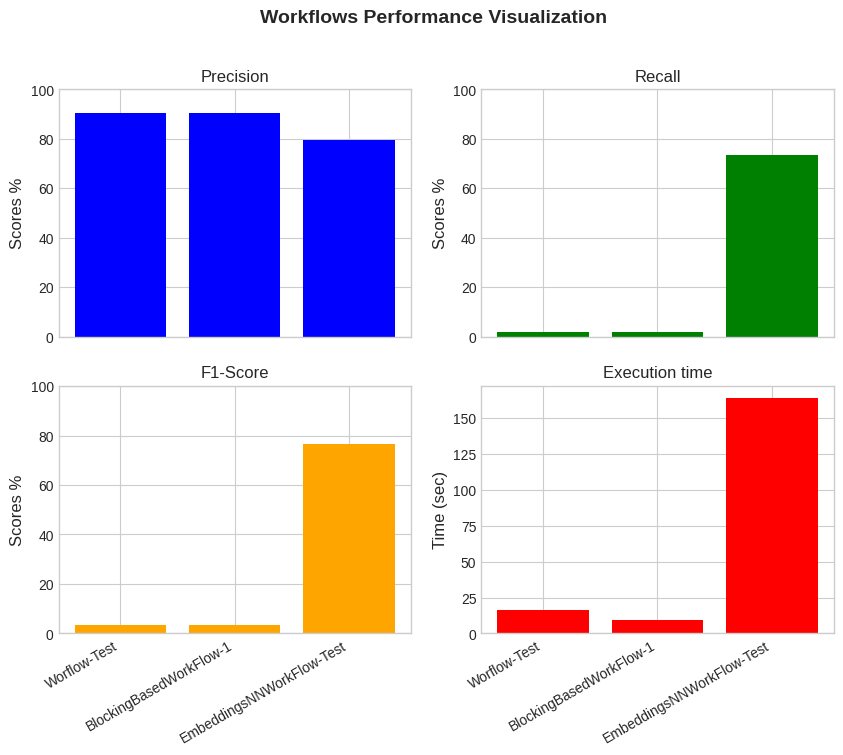

,Name,F1,Recall,Precision,Runtime (sec)
0,Worflow-Test,3.463993,1.765799,90.476190,16.132164
1,BlockingBasedWorkFlow-1,3.463993,1.765799,90.476190,9.111916
2,EmbeddingsNNWorkFlow-Test,76.410999,73.605948,79.438315,164.297292


In [13]:
compare_workflows([w, w1, w2], with_visualization=True)

# Predefined workflows (best & default)

In [14]:
w = BlockingBasedWorkFlow()
w.best_blocking_workflow_ccer()
w.run(data, verbose=True)

***************************************************************************************************************************
                                         Μethod:  Standard Blocking
***************************************************************************************************************************
Method name: Standard Blocking
Parameters: 
Runtime: 0.6960 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.12% 
	Recall:        99.81%
	F1-score:       0.24%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
***************************************************************************************************************************
                                         Μethod:  Block Filtering
***********************************************************************************************

<hr>
<div align="right">
K. Nikoletos, J. Maciejewski, G. Papadakis & M. Koubarakis
</div>
<div align="right">
<a href="https://github.com/Nikoletos-K/pyJedAI/blob/main/LICENSE">Apache License 2.0</a>
</div>